## Code to compare original EQT performance to Seisbench EQT performance

#### What I have done here is run the original EQT model from https://github.com/smousavi05/EQTransformer, as well as supposedly the "same" EQT model available through seisbench https://github.com/seisbench/seisbench, on the same day of data for a subset of the AACSE stations. In both scenarios, I bandpass filtered the data between 5-20 Hz prior to applying the models.

#### This exercise was done as a "gut check" to ensure that the trained model available via seisbench is identical to the original model published by Mousavi et al. Based on the following results, it is not, and though the models show similar results, the original EQT from Mousavi et al. appears to be trained much more robustly.

In [46]:
import numpy as np
import pandas as pd
import shutil
import os
from zipfile import ZipFile
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import obspy
import glob2 as glob

#### Pull in original EQT results from one day of data: 2019/05/27

Do some manipulation to get the pick results into a format to compare to seisbench

In [2]:
base_dir = '/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_all/'
res_files = glob.glob(base_dir + '**/X*results.csv')
eqt = pd.concat([pd.read_csv(f) for f in res_files])
# Since P and S waves are save together, need to split them to compare--
eqt_p = eqt.drop(columns=['s_arrival_time','s_probability','s_uncertainty','s_snr'])
eqt_p=eqt_p.rename(columns={'p_arrival_time': "arrival_time", 'p_probability': "probability",'p_uncertainty':"uncertainty",'p_snr':"snr"})
eqt_p['arrival_time']=pd.to_datetime(eqt_p['arrival_time'],infer_datetime_format=True)
eqt_p = eqt_p.dropna(subset=['arrival_time'])
eqt_s = eqt.drop(columns=['p_arrival_time','p_probability','p_uncertainty','p_snr'])
eqt_s=eqt_s.rename(columns={'s_arrival_time': "arrival_time", 's_probability': "probability",'s_uncertainty':"uncertainty",'s_snr':"snr"})
eqt_s['arrival_time']=pd.to_datetime(eqt_s['arrival_time'],infer_datetime_format=True)
eqt_s = eqt_s.dropna(subset=['arrival_time'])
eqt_p['phase']=['P']*len(eqt_p)
eqt_s['phase']=['S']*len(eqt_s)
eqt = pd.concat([eqt_p,eqt_s])
eqt.head()

,file_name,network,station,instrument_type,station_lat,station_lon,station_elv,event_start_time,event_end_time,detection_probability,detection_uncertainty,arrival_time,probability,uncertainty,snr,phase
0,EP15/XO.EP15..HHE__20190527T000000Z__20190528T...,XO,EP15,HH,58.9664,-155.0867,249.0,2019-05-27 05:57:49.060000,2019-05-27 05:58:10.860000,0.99,NaN,2019-05-27 05:57:49.060,0.83,NaN,11.5,P
1,EP15/XO.EP15..HHE__20190527T000000Z__20190528T...,XO,EP15,HH,58.9664,-155.0867,249.0,2019-05-27 09:52:44.230000,2019-05-27 09:53:08.910000,0.62,NaN,2019-05-27 09:52:44.250,0.43,NaN,30.9,P
2,EP15/XO.EP15..HHE__20190527T000000Z__20190528T...,XO,EP15,HH,58.9664,-155.0867,249.0,2019-05-27 09:57:42.930000,2019-05-27 09:58:05.990000,0.56,NaN,2019-05-27 09:57:42.930,0.79,NaN,16.7,P
4,EP15/XO.EP15..HHE__20190527T000000Z__20190528T...,XO,EP15,HH,58.9664,-155.0867,249.0,2019-05-27 10:51:07.020000,2019-05-27 10:51:32.530000,0.99,NaN,2019-05-27 10:51:07.050,0.64,NaN,20.0,P
5,EP15/XO.EP15..HHE__20190527T000000Z__20190528T...,XO,EP15,HH,58.9664,-155.0867,249.0,2019-05-27 11:01:46.770000,2019-05-27 11:02:05.240000,0.96,NaN,2019-05-27 11:01:46.860,0.7,NaN,5.3,P


#### Pull in seisbench results from the same day

In [3]:
seisb = pd.read_parquet('/home/zkrauss/lynx/picks_20190527_bp0520_overlapped.parquet')
seisb['timestamp']=pd.to_datetime(seisb['timestamp'],infer_datetime_format=True)
seisb.head()

,level_0,index,id,network,station,channel,phase,timestamp,prob,raw_amp,den_amp,z_raw_snr,z_den_snr,n_raw_snr,n_den_snr,e_raw_snr,e_den_snr,dupes
0,0,0,XO.LT01..HH,XO,LT01,HH,P,2019-05-27 00:01:36.343,0.838467,39598.287096,39598.287096,390.770053,390.770053,1244.522645,1244.522645,358.218298,358.218298,False
1,1,1,XO.WD50..HH,XO,WD50,HH,P,2019-05-27 00:04:05.230,0.326362,184.499639,184.499639,1.264470,1.264470,1.494573,1.494573,1.554277,1.554277,False
2,2,2,XO.WD59..HH,XO,WD59,HH,S,2019-05-27 00:04:58.408,0.692439,143649.923170,143649.923170,59.284962,59.284962,134.079618,134.079618,93.055119,93.055119,False
3,3,4,XO.WD70..HH,XO,WD70,HH,P,2019-05-27 00:05:05.259,0.376784,62.007264,62.007264,0.634228,0.634228,1.858469,1.858469,3.191601,3.191601,False
4,4,3,XO.LA39..HH,XO,LA39,HH,P,2019-05-27 00:05:05.261,0.340782,37.157085,37.157085,0.587917,0.587917,0.721593,0.721593,2.049232,2.049232,False


### Compare the two! They SHOULD be exactly the same, IF the models are identical and the peak-picking postprocessing is identical.

#### I already know that the peak-picking postprocessing is not the same, since for the seisbench picks I used the method employed by the authors of PhaseNet to pick peaks (https://github.com/wayneweiqiang/PhaseNet/blob/f119e28e8ebe9f4e7771cd7df8c1ec015aa09cbb/phasenet/postprocess.py), which is not used by EQTransformer. 

#### But, let's go ahead and see how much they differ.

In [47]:
# Sort both dataframes by time:
eqt.sort_values(by=['arrival_time'],inplace=True)
seisb.sort_values(by=['timestamp'],inplace=True)

# Merge dataframes, only merging picks if they have matching station ID, 
# phase type, and are within 0.1 s of each other
resid_max = 0.1
comp = pd.merge_asof(left=eqt,right=seisb,left_on=['arrival_time'],right_on=['timestamp'],left_by=['network','station','instrument_type','phase'],right_by=['network','station','channel','phase'],tolerance = pd.Timedelta(resid_max,'seconds'),direction='nearest')


In [48]:
comp

,file_name,network,station,instrument_type,station_lat,station_lon,station_elv,event_start_time,event_end_time,detection_probability,...,prob,raw_amp,den_amp,z_raw_snr,z_den_snr,n_raw_snr,n_den_snr,e_raw_snr,e_den_snr,dupes
0,KS11/XO.KS11..HHE__20190527T000000Z__20190528T...,XO,KS11,HH,57.1277,-153.0879,39.0,2019-05-27 00:00:04.109996,2019-05-27 00:00:14.349996,0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LT03/XO.LT03..HH2__20190527T000000Z__20190528T...,XO,LT03,HH,57.8668,-154.1665,-202.0,2019-05-27 00:00:04.054900,2019-05-27 00:00:14.554900,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WD55/XO.WD55..HH1__20190527T000000Z__20190528T...,XO,WD55,HH,55.761625,-153.662817,-1283.5,2019-05-27 00:00:09.083600,2019-05-27 00:00:17.773600,0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WD54/XO.WD54..HHZ__20190527T000000Z__20190528T...,XO,WD54,HH,56.331433,-149.066665,-4520.4,2019-05-27 00:00:10.839600,2019-05-27 00:00:16.869600,0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WD54/XO.WD54..HHZ__20190527T000000Z__20190528T...,XO,WD54,HH,56.331433,-149.066665,-4520.4,2019-05-27 00:00:49.169600,2019-05-27 00:00:53.479600,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,WD53/XO.WD53..HH1__20190527T000000Z__20190528T...,XO,WD53,HH,53.779448,-153.422908,-4645.7,2019-05-27 23:47:22.945700,2019-05-27 23:47:30.055700,0.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2194,WD58/XO.WD58..HH1__20190527T000000Z__20190528T...,XO,WD58,HH,53.906227,-155.035345,-4493.3,2019-05-27 23:47:24.235500,2019-05-27 23:47:27.945500,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2195,WD53/XO.WD53..HH1__20190527T000000Z__20190528T...,XO,WD53,HH,53.779448,-153.422908,-4645.7,2019-05-27 23:47:22.945700,2019-05-27 23:47:30.055700,0.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2196,LA30/XO.LA30..HH2__20190527T000000Z__20190528T...,XO,LA30,HH,54.6727,-157.4203,-1564.0,2019-05-27 23:48:06.700000,2019-05-27 23:48:07.230000,0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We see that the seisbench version got over twice as many picks:

In [68]:
print('EQTransformer got',str(len(eqt)),'picks for the day.')
print("Seisbench's version of EQTransformer got",str(len(seisb)),'picks for the day.')

EQTransformer got 2198 picks for the day.
Seisbench's version of EQTransformer got 4925 picks for the day.


EQTransformer got 2198 picks for the day.
Seisbench's version of EQTransformer got 4925 picks for the day.

### So, clearly, EQTransformer's method of peak picking does a much better job of filtering out picks which are likely erroneous. That's a solvable problem though, as long as the correct picks are the same between the two. How many of the picks that EQTransformer found are also found by Seisbench?

In [52]:
matched = comp.dropna(subset=['prob'])
print("Seisbench's version of EQT got only",str(len(matched)),'of the same picks as the original EQT.')

Seisbench's version of EQT got only 649 of the same picks as the original EQT.


Seisbench's version of EQT got only 649 of the same picks as the original EQT.

### OK, that is not good. 

### Here's a rather messy but informative figure that allows us to see at a glance the number of picks throughout time made by both EQT and Seisbench, in relation to the probability assigned to the pick by both models. 

#### This figure shows that there is not a huge difference in performance between the two phase types, and also no clear trend in difference of probabilities between the two models.

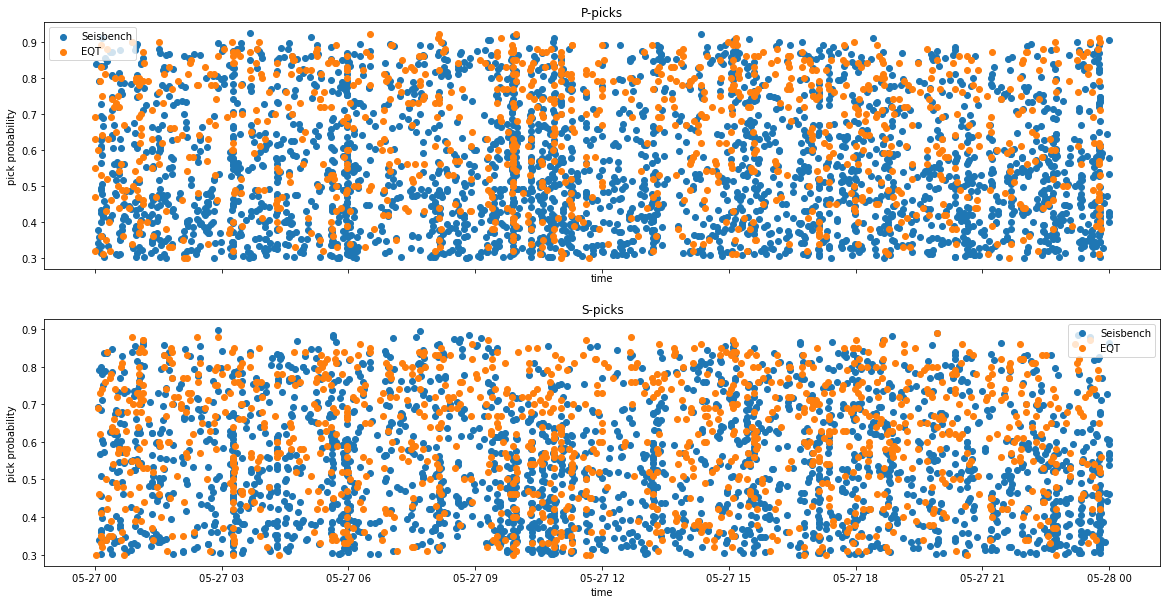

In [8]:
eqtp_picks = eqt[eqt['phase']=='P']
eqts_picks = eqt[eqt['phase']=='S']

sbppicks = seisb[seisb['phase']=='P']
sbspicks = seisb[seisb['phase']=='S']

# Filter by probability?
fig, axs = plt.subplots(2,1, figsize=(20,10),sharex=True)


axs[0].scatter(sbppicks['timestamp'],sbppicks['prob'])
#axs[0].scatter(sbppicks['timestamp'],[0.5]*len(sbppicks))
axs[0].scatter(eqtp_picks['arrival_time'],eqtp_picks['probability'])
#axs[0].scatter(eqtp_picks['arrival_time'],[0.5]*len(eqtp_picks))
axs[0].set_xlabel('time')
axs[0].set_ylabel('pick probability')
axs[0].set_title('P-picks')
axs[0].legend(['Seisbench','EQT'])

axs[1].scatter(sbspicks['timestamp'],sbspicks['prob'])
#axs[1].scatter(sbspicks['timestamp'],[0.5]*len(sbspicks))
axs[1].scatter(eqts_picks['arrival_time'],eqts_picks['probability'])
#axs[1].scatter(eqts_picks['arrival_time'],[0.5]*len(eqts_picks))
axs[1].set_xlabel('time')
axs[1].set_ylabel('pick probability')
axs[1].set_title('S-picks')
axs[1].legend(['Seisbench','EQT'])

#axs[0].set_xlim([datetime(2019,5,27),datetime(2019,5,27,1)])


## Okay, so obviously the peak-picking process is different. But are the probability curves of the annotated streams themselves different? That is what would be most concerning, since it would mean that the Seisbench EQT model was trained differently than the original Mousavi model. Let's plot up some examples to see.

In [31]:
import h5py
import obspy
from obspy.clients.fdsn import Client
import seisbench
import seisbench.models as sbm
client = Client("iris")

#### Here, in our first example, the EQT and Seisbench probability curves look very similar. That is encouraging! However, we see that they are not identical-- the Seisbench P-wave probability curve has a small extra peak just before the P-arrival, and the S-wave peak has a different amplitude between the two models. Hmm.

Text(0.5, 0, 'Time (s)')

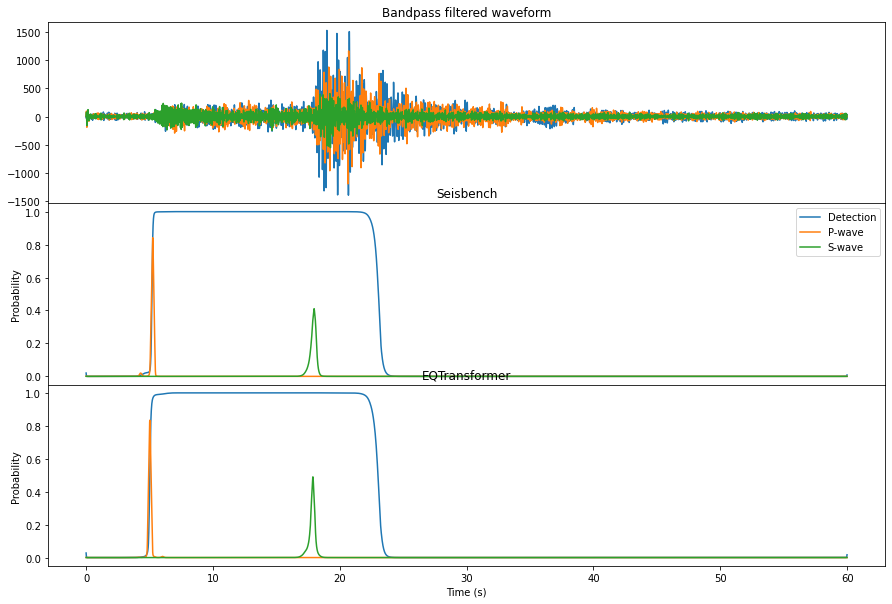

In [59]:
filename='/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_forfigs/EP22_outputs/prediction_probabilities.hdf5'
f = h5py.File(filename, 'r')
list(f.keys())
dset = f['2019-05-27 03:15:18.009998']
d_prob = dset['Earthquake'][:]
p_prob = dset['P_arrival'][:]
s_prob = dset['S_arrival'][:]

t1 = obspy.UTCDateTime('2019-05-27T03:15:18.009998')
t2 = t1 + 60
st = client.get_waveforms("XO", "EP22", "--", "HH*", t1, t2)
st.filter('bandpass',freqmin=5,freqmax=20)
# Load model
model = sbm.EQTransformer.from_pretrained("original")
model.default_args["blinding"] = (0,0)
sb = model.annotate(st)



fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(st[0].times(),st[0].data) 
axs[0].plot(st[1].times(),st[1].data) 
axs[0].plot(st[2].times(),st[2].data) 
axs[0].set_title('Bandpass filtered waveform')

axs[1].plot(sb[0].times(),sb[0].data) 
axs[1].plot(sb[1].times(),sb[1].data) 
axs[1].plot(sb[2].times(),sb[2].data) 
axs[1].legend(['Detection','P-wave','S-wave'])
axs[1].set_title('Seisbench')
axs[1].set_ylabel('Probability')

axs[2].plot(sb[0].times()[0:6000],d_prob) 
axs[2].plot(sb[1].times()[0:6000],p_prob) 
axs[2].plot(sb[2].times()[0:6000],s_prob) 
axs[2].set_title('EQTransformer')
axs[2].set_ylabel('Probability')
axs[2].set_xlabel('Time (s)')

#### This next example is quite concerning. EQT finds two earthquakes within the window, but Seisbench finds nothing.

Text(0.5, 0, 'Time (s)')

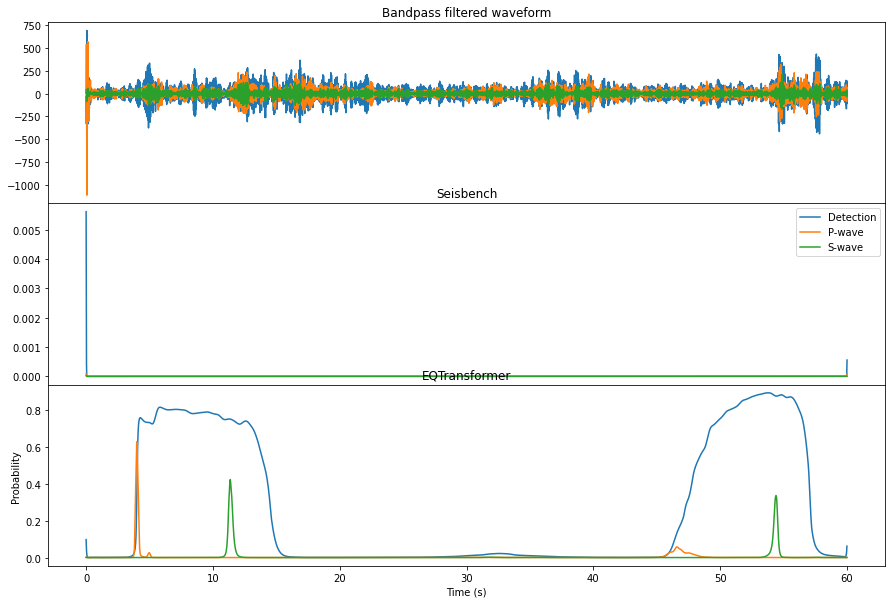

In [62]:
filename='/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_forfigs/KS11_outputs/prediction_probabilities.hdf5'
f = h5py.File(filename, 'r')
list(f.keys())
dset = f['2019-05-27 00:00:00.009996']
d_prob = dset['Earthquake'][:]
p_prob = dset['P_arrival'][:]
s_prob = dset['S_arrival'][:]

t1 = obspy.UTCDateTime('2019-05-27T00:00:00.009996')
t2 = t1 + 60
st = client.get_waveforms("XO", "KS11", "--", "HH*", t1, t2)
st.filter('bandpass',freqmin=5,freqmax=20)
# Load model
model = sbm.EQTransformer.from_pretrained("original")
model.default_args["blinding"] = (0,0)
sb = model.annotate(st)



fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(st[0].times(),st[0].data) 
axs[0].plot(st[1].times(),st[1].data) 
axs[0].plot(st[2].times(),st[2].data) 
axs[0].set_title('Bandpass filtered waveform')

axs[1].plot(sb[0].times(),sb[0].data) 
axs[1].plot(sb[1].times(),sb[1].data) 
axs[1].plot(sb[2].times(),sb[2].data) 
axs[1].legend(['Detection','P-wave','S-wave'])
axs[1].set_title('Seisbench')

axs[2].plot(sb[0].times()[0:6000],d_prob) 
axs[2].plot(sb[1].times()[0:6000],p_prob) 
axs[2].plot(sb[2].times()[0:6000],s_prob) 
axs[2].set_title('EQTransformer')
axs[2].set_ylabel('Probability')
axs[2].set_xlabel('Time (s)')

#### The following example shows that both models detect an earthquake, but only the EQT model finds both a P and S wave peak > 0.3 probability.

Text(0.5, 0, 'Time (s)')

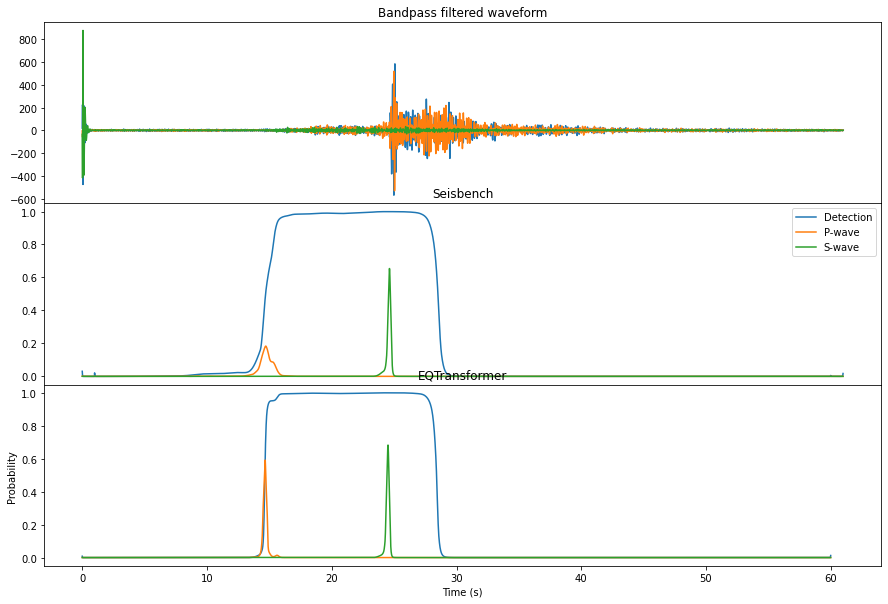

In [63]:
filename='/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_forfigs/LA32_outputs/prediction_probabilities.hdf5'
f = h5py.File(filename, 'r')
list(f.keys())
dset = f['2019-05-27 13:11:41.999600']
d_prob = dset['Earthquake'][:]
p_prob = dset['P_arrival'][:]
s_prob = dset['S_arrival'][:]

t1 = obspy.UTCDateTime('2019-05-27T13:11:41.999600')
t2 = t1 + 61
st = client.get_waveforms("XO", "LA32", "--", "HH*", t1, t2)
st.filter('bandpass',freqmin=5,freqmax=20)
# Load model
model = sbm.EQTransformer.from_pretrained("original")
model.default_args["blinding"] = (0,0)
sb = model.annotate(st)



fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(st[0].times(),st[0].data) 
axs[0].plot(st[1].times(),st[1].data) 
axs[0].plot(st[2].times(),st[2].data) 
axs[0].set_title('Bandpass filtered waveform')

axs[1].plot(sb[0].times(),sb[0].data) 
axs[1].plot(sb[1].times(),sb[1].data) 
axs[1].plot(sb[2].times(),sb[2].data) 
axs[1].legend(['Detection','P-wave','S-wave'])
axs[1].set_title('Seisbench')

axs[2].plot(sb[0].times()[0:6000],d_prob) 
axs[2].plot(sb[1].times()[0:6000],p_prob) 
axs[2].plot(sb[2].times()[0:6000],s_prob) 
axs[2].set_title('EQTransformer')
axs[2].set_ylabel('Probability')
axs[2].set_xlabel('Time (s)')

#### And the following examples just show more of the same. Yikes! The Seisbench model is certainly not the same as the original EQT model, and from these first glance examples, performs not nearly as well!

Text(0.5, 1.0, 'EQTransformer')

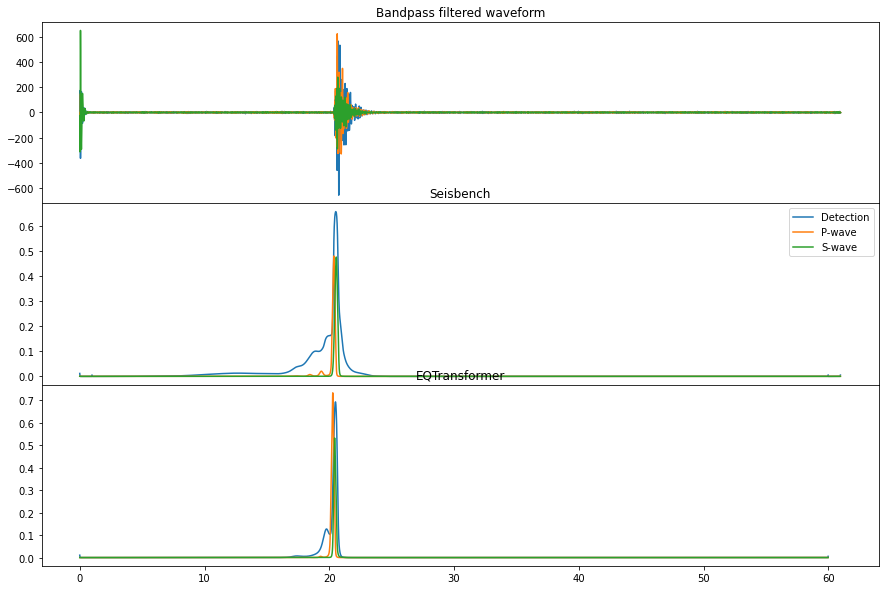

In [64]:
filename='/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_forfigs/LA32_outputs/prediction_probabilities.hdf5'
f = h5py.File(filename, 'r')
list(f.keys())
dset = f['2019-05-27 15:09:17.999600']
d_prob = dset['Earthquake'][:]
p_prob = dset['P_arrival'][:]
s_prob = dset['S_arrival'][:]

t1 = obspy.UTCDateTime('2019-05-27T15:09:17.999600')
t2 = t1 + 61
st = client.get_waveforms("XO", "LA32", "--", "HH*", t1, t2)
st.filter('bandpass',freqmin=5,freqmax=20)
# Load model
model = sbm.EQTransformer.from_pretrained("original")
model.default_args["blinding"] = (0,0)
sb = model.annotate(st)



fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(st[0].times(),st[0].data) 
axs[0].plot(st[1].times(),st[1].data) 
axs[0].plot(st[2].times(),st[2].data) 
axs[0].set_title('Bandpass filtered waveform')

axs[1].plot(sb[0].times(),sb[0].data) 
axs[1].plot(sb[1].times(),sb[1].data) 
axs[1].plot(sb[2].times(),sb[2].data) 
axs[1].legend(['Detection','P-wave','S-wave'])
axs[1].set_title('Seisbench')

axs[2].plot(sb[0].times()[0:6000],d_prob) 
axs[2].plot(sb[1].times()[0:6000],p_prob) 
axs[2].plot(sb[2].times()[0:6000],s_prob) 
axs[2].set_title('EQTransformer')

Text(0.5, 1.0, 'EQTransformer')

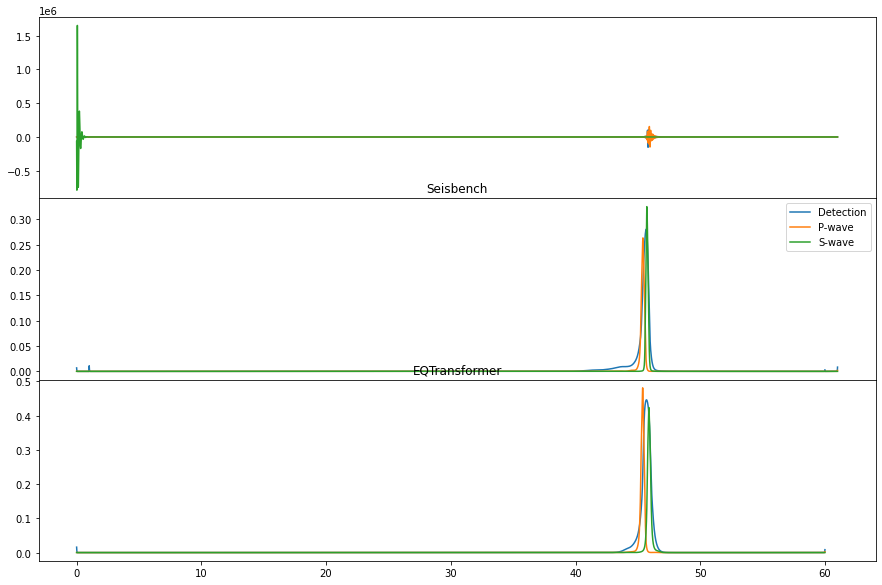

In [41]:
filename='/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_forfigs/WD63_outputs/prediction_probabilities.hdf5'
f = h5py.File(filename, 'r')
list(f.keys())
dset = f['2019-05-27 01:01:36.003000']
d_prob = dset['Earthquake'][:]
p_prob = dset['P_arrival'][:]
s_prob = dset['S_arrival'][:]

t1 = obspy.UTCDateTime('2019-05-27T01:01:36.003000')
t2 = t1 + 61
st = client.get_waveforms("XO", "WD63", "--", "HH*", t1, t2)
st.filter('bandpass',freqmin=5,freqmax=20)
# Load model
model = sbm.EQTransformer.from_pretrained("original")
model.default_args["blinding"] = (0,0)
sb = model.annotate(st)



fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(st[0].times(),st[0].data) 
axs[0].plot(st[1].times(),st[1].data) 
axs[0].plot(st[2].times(),st[2].data) 

axs[1].plot(sb[0].times(),sb[0].data) 
axs[1].plot(sb[1].times(),sb[1].data) 
axs[1].plot(sb[2].times(),sb[2].data) 
axs[1].legend(['Detection','P-wave','S-wave'])
axs[1].set_title('Seisbench')

axs[2].plot(sb[0].times()[0:6000],d_prob) 
axs[2].plot(sb[1].times()[0:6000],p_prob) 
axs[2].plot(sb[2].times()[0:6000],s_prob) 
axs[2].set_title('EQTransformer')

Text(0.5, 1.0, 'EQTransformer')

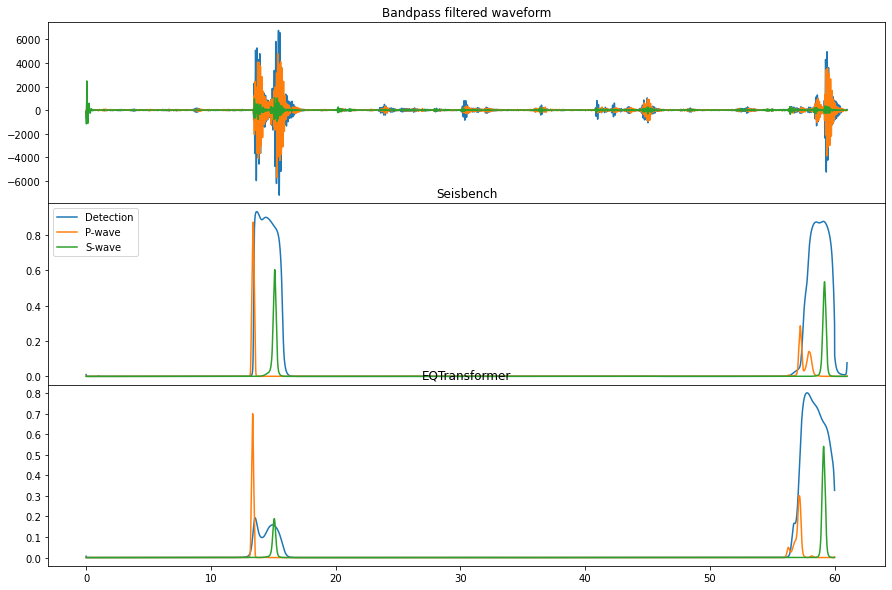

In [65]:
filename='/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_forfigs/WS71_outputs/prediction_probabilities.hdf5'
f = h5py.File(filename, 'r')
list(f.keys())
dset = f['2019-05-27 05:05:54.009800']
d_prob = dset['Earthquake'][:]
p_prob = dset['P_arrival'][:]
s_prob = dset['S_arrival'][:]

t1 = obspy.UTCDateTime('2019-05-27T05:05:54.009800')
t2 = t1 + 61
st = client.get_waveforms("XO", "WS71", "--", "HH*", t1, t2)
st.filter('bandpass',freqmin=5,freqmax=20)
# Load model
model = sbm.EQTransformer.from_pretrained("original")
model.default_args["blinding"] = (0,0)
sb = model.annotate(st)



fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(st[0].times(),st[0].data) 
axs[0].plot(st[1].times(),st[1].data) 
axs[0].plot(st[2].times(),st[2].data) 
axs[0].set_title('Bandpass filtered waveform')

axs[1].plot(sb[0].times(),sb[0].data) 
axs[1].plot(sb[1].times(),sb[1].data) 
axs[1].plot(sb[2].times(),sb[2].data) 
axs[1].legend(['Detection','P-wave','S-wave'])
axs[1].set_title('Seisbench')

axs[2].plot(sb[0].times()[0:6000],d_prob) 
axs[2].plot(sb[1].times()[0:6000],p_prob) 
axs[2].plot(sb[2].times()[0:6000],s_prob) 
axs[2].set_title('EQTransformer')

Text(0.5, 1.0, 'EQTransformer')

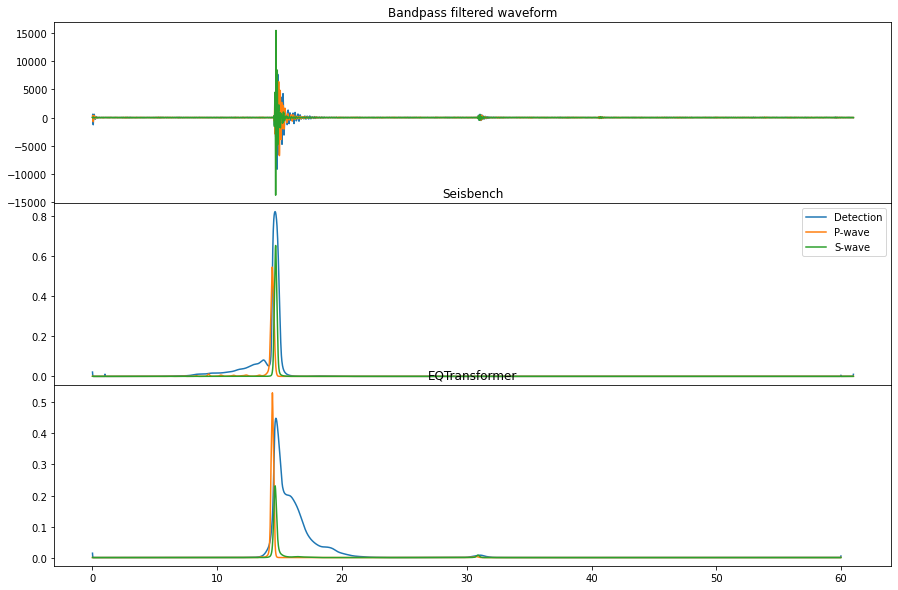

In [66]:
filename='/home/zkrauss/alaska-continuous/krauss-repo/aacse_detection_forfigs/WS71_outputs/prediction_probabilities.hdf5'
f = h5py.File(filename, 'r')
list(f.keys())
dset = f['2019-05-27 18:07:48.009800']
d_prob = dset['Earthquake'][:]
p_prob = dset['P_arrival'][:]
s_prob = dset['S_arrival'][:]

t1 = obspy.UTCDateTime('2019-05-27T18:07:48.009800')
t2 = t1 + 61
st = client.get_waveforms("XO", "WS71", "--", "HH*", t1, t2)
st.filter('bandpass',freqmin=5,freqmax=20)
# Load model
model = sbm.EQTransformer.from_pretrained("original")
model.default_args["blinding"] = (0,0)
sb = model.annotate(st)



fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

axs[0].plot(st[0].times(),st[0].data) 
axs[0].plot(st[1].times(),st[1].data) 
axs[0].plot(st[2].times(),st[2].data) 
axs[0].set_title('Bandpass filtered waveform')

axs[1].plot(sb[0].times(),sb[0].data) 
axs[1].plot(sb[1].times(),sb[1].data) 
axs[1].plot(sb[2].times(),sb[2].data) 
axs[1].legend(['Detection','P-wave','S-wave'])
axs[1].set_title('Seisbench')

axs[2].plot(sb[0].times()[0:6000],d_prob) 
axs[2].plot(sb[1].times()[0:6000],p_prob) 
axs[2].plot(sb[2].times()[0:6000],s_prob) 
axs[2].set_title('EQTransformer')